# Purpose

Figure out pulling location IDs for only DCFC US (non-Tesla to start with) in the US. Need location IDs to efficiently scrape Plugshare with some of our other code.

# Imports

In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
from rich import print
import os
import pandas as pd
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
from typing import List, Union, Set

# from torch.utils.data import DataLoader

from evlens.data.plugshare import MainMapScraper
from evlens.data.google_cloud import BigQuery

# Electrify America in Springfield, VA mall parking lot
TEST_LOCATION = 252784

from dotenv import load_dotenv
load_dotenv(override=True)

from evlens.logs import setup_logger
logger = setup_logger("Notebook-0.3")
logger.info("TEST!")

2024-07-14_T20_23_04EDT: INFO (Notebook-0.3:L26) - TEST!


# Set up our constants

In [2]:
# URL = "https://developer.plugshare.com/embed"
location_id = 252784
URL = f"https://www.plugshare.com/location/{location_id}"

In [3]:
# Load up some example scrapes

from joblib import load
test_results = load("../../test_results.pkl")
df_stations, df_checkins = test_results[0]
df_checkins.drop_duplicates(inplace=True)
df_checkins.info()
df_checkins.head()

<class 'pandas.core.frame.DataFrame'>
Index: 49 entries, 0 to 49
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    49 non-null     datetime64[ns]
 1   car                     49 non-null     object        
 2   connector_type          28 non-null     object        
 3   charge_power_kilowatts  29 non-null     object        
 4   problem                 4 non-null      object        
 5   comment                 27 non-null     object        
 6   location_id             49 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 3.1+ KB


,date,car,connector_type,charge_power_kilowatts,problem,comment,location_id
0,2024-06-30,Genesis GV60 2023,CCS/SAE,245 Kilowatts,NaN,NaN,252784
1,2024-06-29,Kia EV6 2024,CCS/SAE,242 Kilowatts,NaN,NaN,252784
2,2024-06-22,Kia EV6 2022,CCS/SAE,230 Kilowatts,NaN,NaN,252784
3,2024-06-21,Chevrolet Bolt EV 2017,J-1772,NaN,NaN,NaN,252784
4,2024-06-16,Hyundai Ioniq 5 2024,CCS/SAE,242 Kilowatts,NaN,NaN,252784


# Try uploading a screenshot to GCP Cloud Storage

This isn't datatabase stuff but useful for scraping and *should* be easy to do...

In [7]:
from evlens.data.google_cloud import upload_file

upload_file(
    bucket_name='plugshare_scraping',
    source_filepath='../../data/external/plugshare/06-30-2024/errors/07-01-2024_T04_37_46_checkins.png', 
    destination_blob_name='errors/07-01-2024_T04_37_46_checkins.png'
)

2024-07-01_T17_53_05CDT: INFO (evlens.data.google_cloud:L41) - File ../../data/external/plugshare/06-30-2024/errors/07-01-2024_T04_37_46_checkins.png uploaded to errors/07-01-2024_T04_37_46_checkins.png.


In [5]:
# Push our hex data for location ID scraping to the bucket
from evlens.data.google_cloud import upload_file

source_path = "/Users/davemcrench/Projects/evlens/data/processed/h3_hexagons_usa.pkl"

upload_file(
    bucket_name='plugshare_scraping',
    source_filepath=source_path,
    destination_blob_name='location_id_scraping/h3_hexagons_usa.pkl'
)

ConnectionError: ('Connection aborted.', TimeoutError('The write operation timed out'))

# Build Out BigQuery Functionality

In [12]:
from evlens.data.google_cloud import BigQuery

bq = BigQuery()
# bq.create_dataset('plugshare')

## Setup Table Configs and Keys

In [10]:
bq = BigQuery()
bq.list_datasets()

2024-07-04_T10_51_22EDT: WARNING (google.auth._default:L683) - No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
2024-07-04_T10_51_23EDT: INFO (evlens.data.google_cloud:L133) - Datasets in project evlens: ['plugshare']


In [53]:
# Add some key assignments
# bq = BigQuery()
bq.set_table_keys(
    'plugshare',
    'searchTiles',
    "id",
    foreign_keys=None
)

QueryJob<project=evlens, location=US, id=8ba46255-8f1b-4877-bb89-c3faa9c701ac>

In [13]:
bq.setup_table('plugshare', 'locationID', '../../cloud/bq_plugshare_locationIDTable_config.json')

2024-07-16_T22_44_57EDT: INFO (evlens.data.google_cloud:L173) - Created table evlens.plugshare.locationID.


In [14]:
# Add some key assignments
# bq = BigQuery()
bq.set_table_keys(
    'plugshare',
    'locationID',
    "id",
    foreign_keys=[
        {
            'key': 'search_cell_id',
            'foreign_table': bq._make_table_id('plugshare', 'searchTiles'),
            'foreign_column': 'id'
        },
        {
            'key': 'search_cell_id_nrel',
            'foreign_table': bq._make_table_id('plugshare', 'searchTilesNREL'),
            'foreign_column': 'id'
        }
    ]
)

QueryJob<project=evlens, location=US, id=5a2ca475-3bab-4286-8c3d-515f8c69fb58>

In [136]:
bq.setup_table('plugshare', 'stations', '../../cloud/bq_plugshare_stationsTable_config.json')

2024-07-22_T23_15_08EDT: INFO (evlens.data.google_cloud:L173) - Created table evlens.plugshare.stations.


In [137]:
# Add some key assignments
# bq = BigQuery()
bq.set_table_keys(
    'plugshare',
    'stations',
    "id",
    foreign_keys=[
        {
            'key': 'location_id',
            'foreign_table': bq._make_table_id('plugshare', 'locationID'),
            'foreign_column': 'id'
        }
    ]
)

QueryJob<project=evlens, location=US, id=95137248-4daf-404a-9710-15c4271cf5f3>

In [143]:
bq.setup_table('plugshare', 'evses', '../../cloud/bq_plugshare_evseTable_config.json')

2024-07-23_T09_19_31EDT: INFO (evlens.data.google_cloud:L173) - Created table evlens.plugshare.evses.


In [144]:
# Add some key assignments
# bq = BigQuery()
bq.set_table_keys(
    'plugshare',
    'evses',
    "id",
    foreign_keys=[
        {
            'key': 'station_id',
            'foreign_table': bq._make_table_id('plugshare', 'stations'),
            'foreign_column': 'id'
        }
    ]
)

QueryJob<project=evlens, location=US, id=9391ded2-a72b-4359-bdfc-f3552893525a>

In [140]:
bq.setup_table(
    'plugshare',
    'checkins',
    '../../cloud/bq_plugshare_checkinsTable_config.json'
)

2024-07-23_T09_11_20EDT: INFO (evlens.data.google_cloud:L173) - Created table evlens.plugshare.checkins.


In [141]:
# Add some key assignments
# bq = BigQuery()
bq.set_table_keys(
    'plugshare',
    'checkins',
    "id",
    foreign_keys=[
        {
            'key': 'evse_id',
            'foreign_table': bq._make_table_id('plugshare', 'evses'),
            'foreign_column': 'id'
        }
    ]
)

QueryJob<project=evlens, location=US, id=a60b8694-6824-440e-9663-670d1794b034>

## Inserting Data into Checkins Table

In [45]:
import re

def _get_power_number(text: str) -> int:
    '''
    Extracts the value from a power string. E.g. "110 Kilowatts" returns the integer 110.

    Parameters
    ----------
    text : str
        The text to extract the leading number from

    Returns
    -------
    int
        The value in the string
    '''
    if text is None or pd.isna(text):
        return np.nan
    elif isinstance(text, (int, float)):
        return text
    
    match = re.search(r"\d+", text)
    if match:
        return int(match.group(0))
    return np.nan

In [50]:
# Write data to BQ checkins table
df_checkins = test_results[0][1]
df_checkins['id'] = [bq._make_uuid() for _ in range(len(df_checkins))]
df_checkins.rename(columns={'location_id': 'station_id'}, inplace=True)
df_checkins['charge_power_kilowatts'] = df_checkins['charge_power_kilowatts'].apply(_get_power_number)
df_checkins['station_id'] = df_checkins['station_id'].astype(str)
df_checkins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49 entries, 0 to 49
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    49 non-null     datetime64[ns]
 1   car                     49 non-null     object        
 2   connector_type          28 non-null     object        
 3   charge_power_kilowatts  29 non-null     float64       
 4   problem                 4 non-null      object        
 5   comment                 27 non-null     object        
 6   station_id              49 non-null     object        
 7   id                      49 non-null     object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 4.5+ KB


In [47]:
query = f"""
SELECT *
FROM `{bq._make_table_id('plugshare', 'checkins')}`
"""
bq.query_to_dataframe(query)

,id,date,car,problem,connector_type,charge_power_kilowatts,comment,station_id


In [56]:
result = bq.insert_data(
    df_checkins,
    'plugshare',
    'checkins'
)

query = f"""
SELECT *
FROM `{bq._make_table_id('plugshare', 'checkins')}`
"""
df_test = bq.query_to_dataframe(query)
df_test.info()
df_test.sample(5)

2024-07-04_T11_38_10EDT: INFO (evlens.data.google_cloud:L262) - Loaded 245 rows and 8 columns to evlens.plugshare.checkins


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      245 non-null    object
 1   date                    245 non-null    dbdate
 2   car                     245 non-null    object
 3   problem                 20 non-null     object
 4   connector_type          140 non-null    object
 5   charge_power_kilowatts  145 non-null    Int64 
 6   comment                 135 non-null    object
 7   station_id              245 non-null    object
dtypes: Int64(1), dbdate(1), object(6)
memory usage: 15.7+ KB


,id,date,car,problem,connector_type,charge_power_kilowatts,comment,station_id
141,c2539c56-09ad-4eb9-85ad-ba3802e65145,2024-03-15,Ford Mustang Mach-E 2022,NaN,CCS/SAE,156,"Tried #2, charged 4 minutes, stopped. Tried ag...",252784
94,dbe404d1-b726-41ea-8c8a-947bb4cbfa80,2024-04-20,Hyundai Ioniq 5 2022,BROKEN HARDWARE,NaN,<NA>,All stations down,252784
39,6457d145-f3cf-40cb-b4a0-d04e80c7f3df,2024-03-25,Ford Mustang Mach-E 2022,NaN,CCS/SAE,90,Only able to pull 90 kw max and that leveled o...,252784
133,7be05420-79e5-4e9c-81ad-908cd9bfd136,2024-04-08,Volkswagen ID.4 2023,NaN,CCS/SAE,<NA>,NaN,252784
86,72b27d1b-6499-4cef-860e-8264e3b308cf,2024-04-06,Volkswagen ID.4 2023,NaN,CCS/SAE,194,NaN,252784


In [57]:
bq.clear_table('plugshare', 'checkins')

query = f"""
SELECT *
FROM `{bq._make_table_id('plugshare', 'checkins')}`
"""
df_test = bq.query_to_dataframe(query)
df_test.info()

2024-07-04_T11_38_34EDT: INFO (evlens.data.google_cloud:L278) - Table evlens.plugshare.checkins cleared


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      0 non-null      object
 1   date                    0 non-null      object
 2   car                     0 non-null      object
 3   problem                 0 non-null      object
 4   connector_type          0 non-null      object
 5   charge_power_kilowatts  0 non-null      object
 6   comment                 0 non-null      object
 7   station_id              0 non-null      object
dtypes: object(8)
memory usage: 132.0+ bytes


## Inserting Data into Stations Table

In [122]:
# bq.clear_table('plugshare', 'stations')

query = f"""
SELECT *
FROM `{bq._make_table_id('plugshare', 'stations')}`
"""
df_test = bq.query_to_dataframe(query)
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             17 non-null     object        
 1   name           17 non-null     object        
 2   address        17 non-null     object        
 3   plugscore      17 non-null     float64       
 4   wattage        17 non-null     object        
 5   service_hours  17 non-null     object        
 6   checkin_count  17 non-null     Int64         
 7   location_id    17 non-null     object        
 8   last_scraped   17 non-null     datetime64[us]
dtypes: Int64(1), datetime64[us](1), float64(1), object(6)
memory usage: 1.3+ KB


,id,name,address,plugscore,wattage,service_hours,checkin_count,location_id,last_scraped
0,8e31e83f-083f-424a-9daf-34227e2c12f3,Springfield Town Center - Target - East Lot (1),"6600 Springfield Mall, Springfield, Virginia, ...",10.0,7 - 350 kW,Open 24/7,451,252784,2024-07-04 21:19:19.981581
1,c8be84aa-0fef-44f3-b2b7-bc58a31e2547,Springfield Town Center - Target - East Lot (1),"6600 Springfield Mall, Springfield, Virginia, ...",10.0,7 - 350 kW,Open 24/7,451,252784,2024-07-04 21:19:06.570898
2,4e3c584d-b43c-4750-9c2c-376eec06ff65,Springfield Town Center - Target - East Lot (1),"6600 Springfield Mall, Springfield, Virginia, ...",10.0,7 - 350 kW,Open 24/7,451,252784,2024-07-04 21:19:14.051590
3,cf1ef0fa-5f17-4fe2-8eb7-e4f7ba3a3b39,Springfield Town Center - Target - East Lot (1),"6600 Springfield Mall, Springfield, Virginia, ...",10.0,7 - 350 kW,Open 24/7,451,252784,2024-07-04 21:18:30.797877
4,741e748c-8a1a-4976-8468-3206c746a504,Springfield Town Center - Target - East Lot (1),"6600 Springfield Mall, Springfield, Virginia, ...",10.0,7 - 350 kW,Open 24/7,451,252784,2024-07-04 21:18:44.736356


In [119]:
query = f"""
SELECT *
FROM `{bq._make_table_id('plugshare', 'checkins')}`
"""
df_test = bq.query_to_dataframe(query)
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      650 non-null    object
 1   date                    650 non-null    dbdate
 2   car                     650 non-null    object
 3   problem                 39 non-null     object
 4   connector_type          351 non-null    object
 5   charge_power_kilowatts  390 non-null    Int64 
 6   comment                 338 non-null    object
 7   station_id              650 non-null    object
dtypes: Int64(1), dbdate(1), object(6)
memory usage: 41.4+ KB


,id,date,car,problem,connector_type,charge_power_kilowatts,comment,station_id
0,1c7b0ef6-64e9-41c7-8705-d0d488b090cd,2024-03-03,Mercedes EQE 350,NaN,NaN,350,NaN,252784
1,106142c9-2a50-4655-b349-19a434a0213e,2024-03-03,Mercedes EQE 350,NaN,NaN,350,NaN,252784
2,03466962-db15-4684-8ccc-775889e1befa,2024-03-03,Mercedes EQE 350,NaN,NaN,350,NaN,252784
3,5076c6ab-182b-43b2-8582-8344bcf2e483,2024-03-03,Mercedes EQE 350,NaN,NaN,350,NaN,252784
4,bf3fca0b-54f8-48d1-a5c8-f1f35990db91,2024-03-03,Mercedes EQE 350,NaN,NaN,350,NaN,252784


In [121]:
# Write data to BQ stations table
df_stations = test_results[0][0].drop(columns=['id']).drop_duplicates()
df_stations['id'] = [BigQuery.make_uuid() for _ in range(len(df_stations))]
df_stations['location_id'] = str(TEST_LOCATION)
df_stations['plugscore'] = df_stations['plugscore'].astype(float)
# df_stations.rename(columns={'location_id': 'station_id'}, inplace=True)
# df_stations['station_id'] = df_checkins['station_id'].astype(str)
df_stations.info()
df_stations.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 0 to 0
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           1 non-null      object 
 1   address        1 non-null      object 
 2   plugscore      1 non-null      float64
 3   wattage        1 non-null      object 
 4   service_hours  1 non-null      object 
 5   checkin_count  1 non-null      int64  
 6   id             1 non-null      object 
 7   location_id    1 non-null      object 
dtypes: float64(1), int64(1), object(6)
memory usage: 72.0+ bytes


,name,address,plugscore,wattage,service_hours,checkin_count,id,location_id
0,Springfield Town Center - Target - East Lot (1),"6600 Springfield Mall, Springfield, Virginia, ...",10.0,7 - 350 kW,Open 24/7,450,43b83999-5eca-4527-9b41-089f143d9258,252784


In [69]:
table_name = 'stations'

result = bq.insert_data(
    df_stations,
    'plugshare',
    table_name
)

query = f"""
SELECT *
FROM `{bq._make_table_id('plugshare', table_name)}`
"""
df_test = bq.query_to_dataframe(query)
df_test.info()
df_test.head(5)

2024-07-04_T11_55_41EDT: INFO (evlens.data.google_cloud:L263) - Loaded 1 rows and 8 columns to evlens.plugshare.stations


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1 non-null      object 
 1   name           1 non-null      object 
 2   address        1 non-null      object 
 3   plugscore      1 non-null      float64
 4   wattage        1 non-null      object 
 5   service_hours  1 non-null      object 
 6   checkin_count  1 non-null      Int64  
 7   location_id    1 non-null      object 
dtypes: Int64(1), float64(1), object(6)
memory usage: 197.0+ bytes


ValueError: Cannot take a larger sample than population when 'replace=False'

In [70]:
df_test.head(5)

,id,name,address,plugscore,wattage,service_hours,checkin_count,location_id
0,e51dd15f-d1cb-423c-9ef9-571a9c526188,Springfield Town Center - Target - East Lot (1),"6600 Springfield Mall, Springfield, Virginia, ...",10.0,7 - 350 kW,Open 24/7,450,252784


In [63]:
test_results[0][0]

,name,address,plugscore,wattage,service_hours,checkin_count,id
0,Springfield Town Center - Target - East Lot (1),"6600 Springfield Mall, Springfield, Virginia, ...",10,7 - 350 kW,Open 24/7,450,a42bd13a-4480-454d-acdf-f5815fb1cae2
1,Springfield Town Center - Target - East Lot (1),"6600 Springfield Mall, Springfield, Virginia, ...",10,7 - 350 kW,Open 24/7,450,dd136ee1-84b7-4903-a640-d14e8c6e7abc


## Clearing Data Tables

When you want that "super fresh" feeling. Commented out so nothing bad happens by accident!

In [145]:
# from evlens.data.google_cloud import BigQuery
# bq = BigQuery()

# bq.clear_table('plugshare', 'locationID')
# bq.clear_table('plugshare', 'checkins')
# bq.clear_table('plugshare', 'stations')
# bq.clear_table('plugshare', 'evses')

2024-07-23_T09_19_59EDT: INFO (evlens.data.google_cloud:L279) - Table evlens.plugshare.checkins cleared
2024-07-23_T09_20_01EDT: INFO (evlens.data.google_cloud:L279) - Table evlens.plugshare.stations cleared
2024-07-23_T09_20_03EDT: INFO (evlens.data.google_cloud:L279) - Table evlens.plugshare.evses cleared


## Loading in Hexagon Data

In [75]:
import geopandas as gpd

df_hex = pd.read_pickle('../../data/processed/h3_hexagons_usa.pkl')
df_hex.info()
df_hex.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1812316 entries, 872631cacffffff to 872b99662ffffff
Data columns (total 5 columns):
 #   Column     Dtype   
---  ------     -----   
 0   geometry   geometry
 1   cell_area  float64 
 2   lat_long   object  
 3   latitude   float64 
 4   longitude  float64 
dtypes: float64(3), geometry(1), object(1)
memory usage: 83.0+ MB


,geometry,cell_area,lat_long,latitude,longitude
h3_polyfill,,,,,
872631cacffffff,"POLYGON ((-98.89411 45.47622, -98.90505 45.466...",2.011903,"(45.4644308268348, -98.88678418817953)",45.464431,-98.886784
872aad931ffffff,"POLYGON ((-74.65316 39.46713, -74.6674 39.4605...",1.956755,"(39.45501532030005, -74.65252127744267)",39.455015,-74.652521
872a91d64ffffff,"POLYGON ((-82.96187 39.80834, -82.97493 39.800...",1.960595,"(39.79630739720016, -82.95910787730979)",39.796307,-82.959108
870c2e831ffffff,"POLYGON ((-153.77099 65.74139, -153.79115 65.7...",1.961247,"(65.7299171835115, -153.760950462319)",65.729917,-153.760950
8729b0666ffffff,"POLYGON ((-113.61065 34.98822, -113.60209 34.9...",2.262247,"(34.99986610719769, -113.61867862603036)",34.999866,-113.618679


In [74]:
df_hex.shape

(1812316, 5)

In [79]:
df_hex.reset_index(inplace=True)
df_hex.info()
df_hex.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1812316 entries, 0 to 1812315
Data columns (total 6 columns):
 #   Column       Dtype   
---  ------       -----   
 0   h3_polyfill  object  
 1   geometry     geometry
 2   cell_area    float64 
 3   lat_long     object  
 4   latitude     float64 
 5   longitude    float64 
dtypes: float64(3), geometry(1), object(2)
memory usage: 83.0+ MB


,h3_polyfill,geometry,cell_area,lat_long,latitude,longitude
0,872631cacffffff,"POLYGON ((-98.89411 45.47622, -98.90505 45.466...",2.011903,"(45.4644308268348, -98.88678418817953)",45.464431,-98.886784
1,872aad931ffffff,"POLYGON ((-74.65316 39.46713, -74.6674 39.4605...",1.956755,"(39.45501532030005, -74.65252127744267)",39.455015,-74.652521
2,872a91d64ffffff,"POLYGON ((-82.96187 39.80834, -82.97493 39.800...",1.960595,"(39.79630739720016, -82.95910787730979)",39.796307,-82.959108
3,870c2e831ffffff,"POLYGON ((-153.77099 65.74139, -153.79115 65.7...",1.961247,"(65.7299171835115, -153.760950462319)",65.729917,-153.760950
4,8729b0666ffffff,"POLYGON ((-113.61065 34.98822, -113.60209 34.9...",2.262247,"(34.99986610719769, -113.61867862603036)",34.999866,-113.618679


In [80]:
# Setup the table
table_name = 'searchTiles'

bq.setup_table('plugshare', table_name, '../../cloud/bq_plugshare_searchTilesTable_config.json')

2024-07-04_T12_05_59EDT: INFO (evlens.data.google_cloud:L173) - Created table evlens.plugshare.searchTiles.


In [82]:
query = f"""
SELECT *
FROM `{bq._make_table_id('plugshare', table_name)}`
"""
df_test = bq.query_to_dataframe(query)
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              0 non-null      object
 1   h3_polyfill     0 non-null      object
 2   cell_radius_mi  0 non-null      object
 3   latitude        0 non-null      object
 4   longitude       0 non-null      object
dtypes: object(5)
memory usage: 132.0+ bytes


,id,h3_polyfill,cell_radius_mi,latitude,longitude


In [88]:
df_hex['cell_radius_mi'] = np.sqrt(2 * df_hex['cell_area'] / (3 * np.sqrt(3)))

0    0.879990
1    0.867845
2    0.868696
3    0.868841
4    0.933134
Name: cell_area, dtype: float64

In [89]:
# Massage a bit more to match schema
df_hex['id'] = [BigQuery.make_uuid() for _ in range(len(df_hex))]
df_hex['cell_radius_mi'] = np.sqrt(2 * df_hex['cell_area'] / (3 * np.sqrt(3)))
df_hex.drop(columns=['geometry', 'cell_area', 'lat_long'], inplace=True)
df_hex.info()
df_hex.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1812316 entries, 0 to 1812315
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   h3_polyfill     object 
 1   latitude        float64
 2   longitude       float64
 3   id              object 
 4   cell_radius_mi  float64
dtypes: float64(3), object(2)
memory usage: 69.1+ MB


,h3_polyfill,latitude,longitude,id,cell_radius_mi
0,872631cacffffff,45.464431,-98.886784,811d4a85-037a-4616-b944-2559c96ae459,0.879990
1,872aad931ffffff,39.455015,-74.652521,87da4db7-adb7-4959-9a32-a687c737416a,0.867845
2,872a91d64ffffff,39.796307,-82.959108,6394025e-d327-4cd7-bcd4-1f87f295ef09,0.868696
3,870c2e831ffffff,65.729917,-153.760950,4c2d3a79-bc76-4227-83d3-27cb250ec92a,0.868841
4,8729b0666ffffff,34.999866,-113.618679,59e77095-7f9a-47af-918c-7cf66abca1c4,0.933134


In [91]:
df_hex['cell_radius_mi'].describe()

count    1.812316e+06
mean     8.823830e-01
std      3.479788e-02
min      7.763017e-01
25%      8.592466e-01
50%      8.831516e-01
75%      9.070450e-01
max      9.532796e-01
Name: cell_radius_mi, dtype: float64

In [92]:
bq.clear_table('plugshare', table_name)

result = bq.insert_data(
    df_hex,
    'plugshare',
    table_name
)

2024-07-04_T12_15_31EDT: INFO (evlens.data.google_cloud:L279) - Table evlens.plugshare.searchTiles cleared
2024-07-04_T12_19_18EDT: INFO (evlens.data.google_cloud:L263) - Loaded 1812316 rows and 5 columns to evlens.plugshare.searchTiles


In [93]:
query = f"""
SELECT *
FROM `{bq._make_table_id('plugshare', table_name)}`
LIMIT 5
"""
df_test = bq.query_to_dataframe(query)
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5 non-null      object 
 1   h3_polyfill     5 non-null      object 
 2   cell_radius_mi  5 non-null      float64
 3   latitude        5 non-null      float64
 4   longitude       5 non-null      float64
dtypes: float64(3), object(2)
memory usage: 332.0+ bytes


,id,h3_polyfill,cell_radius_mi,latitude,longitude
0,811d4a85-037a-4616-b944-2559c96ae459,872631cacffffff,0.879990,45.464431,-98.886784
1,87da4db7-adb7-4959-9a32-a687c737416a,872aad931ffffff,0.867845,39.455015,-74.652521
2,6394025e-d327-4cd7-bcd4-1f87f295ef09,872a91d64ffffff,0.868696,39.796307,-82.959108
3,4c2d3a79-bc76-4227-83d3-27cb250ec92a,870c2e831ffffff,0.868841,65.729917,-153.760950
4,59e77095-7f9a-47af-918c-7cf66abca1c4,8729b0666ffffff,0.933134,34.999866,-113.618679


In [94]:
query = f"""
SELECT COUNT(id)
FROM `{bq._make_table_id('plugshare', table_name)}`
"""
df_test = bq.query_to_dataframe(query)
df_test

,f0_
0,1812316


In [96]:
df_test.iloc[0,0] == len(df_hex)

np.True_

## Loading Data into locationID table

## Narrow down the search

Right now we have A LOT of tiles to search through, but now that we know about the [NREL charging stations API](https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/), maybe we can get the vast majority of the data we need by using lat/long of the stations NREL knows about instead?

In [82]:
from evlens.data.nrel_api import AFDC
a = AFDC()
df_nrel_stations = a.get_stations()
df_nrel_stations.info()
df_nrel_stations

2024-07-15_T15_16_40EDT: INFO (evlens.data.nrel_api:L80) - 10441 total records found, comprised of 43763 plugs


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10441 entries, 0 to 10440
Data columns (total 74 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   access_code                 10441 non-null  object 
 1   access_days_time            10158 non-null  object 
 2   access_detail_code          1014 non-null   object 
 3   cards_accepted              2280 non-null   object 
 4   date_last_confirmed         10401 non-null  object 
 5   expected_date               0 non-null      object 
 6   fuel_type_code              10441 non-null  object 
 7   groups_with_access_code     10441 non-null  object 
 8   id                          10441 non-null  int64  
 9   maximum_vehicle_class       2338 non-null   object 
 10  open_date                   10432 non-null  object 
 11  owner_type_code             3436 non-null   object 
 12  restricted_access           2555 non-null   object 
 13  status_code                 104

,access_code,access_days_time,access_detail_code,cards_accepted,date_last_confirmed,expected_date,fuel_type_code,groups_with_access_code,id,maximum_vehicle_class,...,rd_blends_fr,rd_max_biodiesel_level,nps_unit_name,access_days_time_fr,intersection_directions_fr,bd_blends_fr,groups_with_access_code_fr,ev_pricing_fr,ev_network_ids,federal_agency
0,public,24 hours daily; pay lot,None,None,2022-06-14,None,ELEC,Public,38309,LD,...,None,None,None,None,None,None,Public,None,NaN,NaN
1,public,24 hours daily; pay lot,None,None,2023-01-10,None,ELEC,Public,38521,LD,...,None,None,None,None,None,None,Public,None,NaN,NaN
2,public,24 hours daily; pay lot,None,None,2024-01-09,None,ELEC,Public,38522,LD,...,None,None,None,None,None,None,Public,None,NaN,NaN
3,public,Dealership business hours,CALL,None,2024-02-12,None,ELEC,Public - Call ahead,39114,LD,...,None,None,None,None,None,None,Public - Appeler à l'avance,None,NaN,NaN
4,public,Dealership business hours,CALL,None,2024-02-12,None,ELEC,Public - Call ahead,39711,LD,...,None,None,None,None,None,None,Public - Appeler à l'avance,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10436,public,24 hours daily,None,None,2024-07-14,None,ELEC,Public,350487,None,...,None,None,None,None,None,None,Public,None,"{'station': ['68278'], 'posts': ['146007', '14...",NaN
10437,public,24 hours daily,None,None,2024-07-15,None,ELEC,Public,350491,None,...,None,None,None,None,None,None,Public,None,{'station': ['d4741bb9-eaa8-4ee1-9c09-950408cd...,NaN
10438,public,24 hours daily,None,None,2024-07-15,None,ELEC,Public,350531,None,...,None,None,None,None,None,None,Public,None,"{'station': ['USCPIL16092481'], 'posts': ['257...",NaN
10439,public,24 hours daily,None,None,2024-07-15,None,ELEC,Public,350553,None,...,None,None,None,None,None,None,Public,None,{'station': ['981041ef-542d-46bd-be82-9e58b4d3...,NaN


In [89]:
df

,id,cell_radius_mi,latitude,longitude,name,num_plugs,ev_connector_types,ev_network,pricing,geocode_accuracy,network_ids
0,38309,1,34.852437,-82.399901,City of Greenville - Richardson Garage,3.0,CHADEMO;J1772;J1772COMBO,Non-Networked,Free,200-9,nan
1,38521,1,34.010528,-118.489800,City of Santa Monica - Civic Parking Garage,14.0,CHADEMO;J1772,Non-Networked,Free,GPS,nan
2,38522,1,39.843886,-104.771138,Denver International Airport - Canopy Airport ...,28.0,CHADEMO;J1772;NEMA515,Non-Networked,Free,GPS,nan
3,39114,1,30.206330,-97.759360,Clay Cooley Nissan,3.0,CHADEMO;J1772,Non-Networked,Free,200-8,nan
4,39711,1,30.374542,-97.731445,Town North Nissan,2.0,CHADEMO;J1772;J1772COMBO,Non-Networked,Free,200-9,nan
...,...,...,...,...,...,...,...,...,...,...,...
10436,350487,1,34.576820,-84.948000,Flying J 632,4.0,J1772COMBO,eVgo Network,None,GPS,"{'station': ['68278'], 'posts': ['146007', '14..."
10437,350491,1,39.985216,-82.870519,Byers Imports DCFC,1.0,J1772COMBO,Blink Network,None,GPS,{'station': ['d4741bb9-eaa8-4ee1-9c09-950408cd...
10438,350531,1,40.409460,-86.857244,LAFAYETTE HYUN SUPER 1,1.0,CHADEMO;J1772COMBO,ChargePoint Network,None,GPS,"{'station': ['USCPIL16092481'], 'posts': ['257..."
10439,350553,1,46.729828,-117.174540,WSU Visitor Center,2.0,J1772COMBO,EV Connect,None,GPS,{'station': ['981041ef-542d-46bd-be82-9e58b4d3...


In [29]:
df_nrel_stations.columns[df_nrel_stations.columns.str.contains("network")]

Index(['ev_network', 'ev_network_web', 'ev_network_ids'], dtype='object')

In [39]:
df_nrel_stations[['latitude', 'longitude']].info()
df_nrel_stations[['latitude', 'longitude']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10444 entries, 0 to 10443
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   10444 non-null  float64
 1   longitude  10444 non-null  float64
dtypes: float64(2)
memory usage: 163.3 KB


,latitude,longitude
0,34.852437,-82.399901
1,34.010528,-118.489800
2,39.843886,-104.771138
3,30.206330,-97.759360
4,30.374542,-97.731445
...,...,...
10439,29.670727,-82.323805
10440,34.576820,-84.948000
10441,39.985216,-82.870519
10442,40.409460,-86.857244


In [47]:
from evlens.data.google_cloud import BigQuery
bq = BigQuery()
bq.setup_table('plugshare', 'searchTilesNREL', '../../cloud/bq_plugshare_searchTilesTable_NREL_config.json')

2024-07-15_T14_30_11EDT: WARNING (google.auth._default:L683) - No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
2024-07-15_T14_30_11EDT: INFO (evlens.data.google_cloud:L173) - Created table evlens.plugshare.searchTilesNREL.


In [55]:
# Add some key assignments
# bq = BigQuery()
bq.set_table_keys(
    'plugshare',
    'searchTilesNREL',
    "id"
)

QueryJob<project=evlens, location=US, id=2ecd903a-7a17-4e29-8752-475677d42b78>

In [90]:
#TODO: ETL the data we have here to match the BQ schema and insert
query = f"""
SELECT *
FROM `{bq._make_table_id('plugshare', 'searchTilesNREL')}`
LIMIT 5
"""
bq_search_tiles_nrel = bq.query_to_dataframe(query)
bq_search_tiles_nrel

,id,cell_radius_mi,latitude,longitude,name,num_plugs,ev_connector_types,ev_network,pricing,geocode_accuracy,network_ids
0,39740,1.0,33.535048,-101.958266,McGavock Nissan,1,CHADEMO;J1772COMBO,Non-Networked,$0.50 per kWh,GPS,nan
1,47549,1.0,36.753060,-76.247500,Nissan of Chesapeake,1,CHADEMO,Non-Networked,Free,200-8,nan
2,60125,1.0,34.072975,-118.444801,University of California Los Angeles - Parking...,1,CHADEMO,Non-Networked,Free,GPS,nan
3,62828,1.0,35.395326,-80.610927,Ben Mynatt Chevrolet Cadillac,1,J1772COMBO,Non-Networked,Free,200-9,nan
4,63350,1.0,36.852443,-76.285958,Scope Arena Parking,1,CHADEMO;J1772COMBO,Non-Networked,Free,GPS,nan


In [95]:
from evlens.data.plugshare import SearchCriterion

TILE_COUNT = 12
    
query = f"""
SELECT *
FROM `{bq._make_table_id('plugshare', 'searchTilesNREL')}`
LIMIT {TILE_COUNT}
"""
search_tiles = bq.query_to_dataframe(query)

def make_criteria(search_tile: SearchCriterion, tile_type: str, map_pan_time: float = 1.5):
    return SearchCriterion(
        latitude=search_tile.latitude,
        longitude=search_tile.longitude,
        radius_in_miles=search_tile.cell_radius_mi,
        search_cell_id=search_tile.id,
        search_cell_id_type=tile_type,
        wait_time_for_map_pan=map_pan_time
    )

TEST_CRITERIA = search_tiles.apply(make_criteria, axis=1, tile_type='NREL')
TEST_CRITERIA

0     Search cell of type 'NREL' at lat/long (33.535...
1     Search cell of type 'NREL' at lat/long (36.753...
2     Search cell of type 'NREL' at lat/long (34.072...
3     Search cell of type 'NREL' at lat/long (35.395...
4     Search cell of type 'NREL' at lat/long (36.852...
5     Search cell of type 'NREL' at lat/long (37.272...
6     Search cell of type 'NREL' at lat/long (39.652...
7     Search cell of type 'NREL' at lat/long (37.490...
8     Search cell of type 'NREL' at lat/long (38.018...
9     Search cell of type 'NREL' at lat/long (35.668...
10    Search cell of type 'NREL' at lat/long (42.197...
11    Search cell of type 'NREL' at lat/long (41.034...
dtype: object

In [98]:
TEST_CRITERIA[0]

Search cell of type 'NREL' at lat/long (33.535048, -101.958266), with a search radius of 1.0 miles.

In [104]:
# Moynihan Train Station - should have only one pin for CCS
TEST_COORDS = (40.7525834,-73.9999498) # Lat, long
RADIUS = 1 # miles
SLEEP_FOR_IFRAME_PAN = 1.5
TEST_CRITERION = SearchCriterion(
    TEST_COORDS[0],
    TEST_COORDS[1],
    RADIUS,
    '811d4a85-037a-4616-b944-2559c96ae459', # fake
    'NREL',
    SLEEP_FOR_IFRAME_PAN
)


In [106]:
from evlens.data.plugshare import LocationIDScraper

lis = LocationIDScraper(
    f"./data/external/plugshare/07-15-2024/",
    timeout=3,
    headless=True,
    progress_bars=True
)
# df_locs = lis.run(TEST_CRITERIA)
df_locs = lis.run([TEST_CRITERION])
df_locs

2024-07-15_T17_00_56EDT: WARNING (google.auth._default:L683) - No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
2024-07-15_T17_00_56EDT: INFO (evlens.data.plugshare:L783) - Beginning location ID scraping!
Searching map tiles: 100%|██████████| 1/1 [00:04<00:00,  4.86s/it]
2024-07-15_T17_01_02EDT: ERROR (evlens.data.plugshare:L850) - Something went horribly wrong, why do we have ZERO locations?!


In [64]:
plug_count_columns = [
    'ev_dc_fast_num',
    'ev_level1_evse_num',
    'ev_level2_evse_num'
]

In [84]:
df = df_nrel_stations.rename(columns={
    'station_name': 'name',
    'ev_pricing': 'pricing',
    'geocode_status': 'geocode_accuracy'
    }, errors='ignore')

df['cell_radius_mi'] = 1
df['num_plugs'] = df_nrel_stations[plug_count_columns].sum(axis=1)
df.ev_connector_types = df_nrel_stations.ev_connector_types.str.join(";")
df['network_ids'] = df_nrel_stations.ev_network_ids.astype(str)

df = df[bq_search_tiles_nrel.columns]

df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10441 entries, 0 to 10440
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10441 non-null  int64  
 1   cell_radius_mi      10441 non-null  int64  
 2   latitude            10441 non-null  float64
 3   longitude           10441 non-null  float64
 4   name                10441 non-null  object 
 5   num_plugs           10441 non-null  float64
 6   ev_connector_types  10441 non-null  object 
 7   ev_network          10441 non-null  object 
 8   pricing             1130 non-null   object 
 9   geocode_accuracy    10441 non-null  object 
 10  network_ids         10441 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 897.4+ KB


,id,cell_radius_mi,latitude,longitude,name,num_plugs,ev_connector_types,ev_network,pricing,geocode_accuracy,network_ids
0,38309,1,34.852437,-82.399901,City of Greenville - Richardson Garage,3.0,CHADEMO;J1772;J1772COMBO,Non-Networked,Free,200-9,nan
1,38521,1,34.010528,-118.489800,City of Santa Monica - Civic Parking Garage,14.0,CHADEMO;J1772,Non-Networked,Free,GPS,nan
2,38522,1,39.843886,-104.771138,Denver International Airport - Canopy Airport ...,28.0,CHADEMO;J1772;NEMA515,Non-Networked,Free,GPS,nan
3,39114,1,30.206330,-97.759360,Clay Cooley Nissan,3.0,CHADEMO;J1772,Non-Networked,Free,200-8,nan
4,39711,1,30.374542,-97.731445,Town North Nissan,2.0,CHADEMO;J1772;J1772COMBO,Non-Networked,Free,200-9,nan
...,...,...,...,...,...,...,...,...,...,...,...
10436,350487,1,34.576820,-84.948000,Flying J 632,4.0,J1772COMBO,eVgo Network,None,GPS,"{'station': ['68278'], 'posts': ['146007', '14..."
10437,350491,1,39.985216,-82.870519,Byers Imports DCFC,1.0,J1772COMBO,Blink Network,None,GPS,{'station': ['d4741bb9-eaa8-4ee1-9c09-950408cd...
10438,350531,1,40.409460,-86.857244,LAFAYETTE HYUN SUPER 1,1.0,CHADEMO;J1772COMBO,ChargePoint Network,None,GPS,"{'station': ['USCPIL16092481'], 'posts': ['257..."
10439,350553,1,46.729828,-117.174540,WSU Visitor Center,2.0,J1772COMBO,EV Connect,None,GPS,{'station': ['981041ef-542d-46bd-be82-9e58b4d3...


In [85]:
bq.insert_data(df, 'plugshare', 'searchTilesNREL')

2024-07-15_T15_17_55EDT: INFO (evlens.data.google_cloud:L263) - Loaded 10441 rows and 11 columns to evlens.plugshare.searchTilesNREL


## Fix the problem with location scraper

Why can't it see the pins anymore?!

In [1]:

%load_ext autoreload
%autoreload 2

import nest_asyncio
nest_asyncio.apply()

from time import sleep
import pandas as pd
import numpy as np
import os
import re
from typing import Tuple, Set, Union, List
from urllib.parse import urlparse

from joblib import dump as joblib_dump

# from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import (
    NoSuchElementException,
    TimeoutException,
    ElementClickInterceptedException,
    ElementNotInteractableException
)
from selenium.webdriver.remote.webelement import WebElement
from selenium.webdriver.chrome.service import Service

from evlens.data.google_cloud import BigQuery
from evlens.data.plugshare import LocationIDScraper, SearchCriterion

from tqdm import tqdm
import ray
from tenacity import retry, wait_random_exponential

from evlens import get_current_datetime

In [2]:
from evlens.data.plugshare import SearchCriterion

TILE_COUNT = 12
    
bq = BigQuery()
query = f"""
SELECT *
FROM `{bq._make_table_id('plugshare', 'searchTilesNREL')}`
LIMIT {TILE_COUNT}
"""
search_tiles = bq.query_to_dataframe(query)

def make_criteria(search_tile: SearchCriterion, tile_type: str, map_pan_time: float = 1.5):
    return SearchCriterion(
        latitude=search_tile.latitude,
        longitude=search_tile.longitude,
        radius_in_miles=search_tile.cell_radius_mi,
        search_cell_id=search_tile.id,
        search_cell_id_type=tile_type,
        wait_time_for_map_pan=map_pan_time
    )

In [5]:
driver.quit()

2024-07-16_T22_34_53EDT: INFO (mitmproxy.proxy.mode_servers:L154) - HTTP(S) proxy at 127.0.0.1:50643 stopped.


In [ ]:
TEST_CRITERIA = search_tiles.apply(make_criteria, axis=1, tile_type='NREL', map_pan_time=2)
TEST_CRITERIA


lis = LocationIDScraper(
    '../../data/external/plugshare/07-15-2024/errors/',
    timeout=3,
    headless=True,
    progress_bars=True
)

driver = lis.driver
wait = lis.wait

EMBEDDED_DEV_MAP_URL = 'https://developer.plugshare.com/embed'
driver.get(EMBEDDED_DEV_MAP_URL)
# driver.get('https://www.plugshare.com/')

lis.pick_plug_filters()
lis.search_location(TEST_CRITERIA[0])
df = lis._catch_api_response()
df.info()
df.head()

2024-07-16_T22_35_26EDT: INFO (seleniumwire2.storage:L37) - Using default request storage
2024-07-16_T22_35_27EDT: INFO (mitmproxy.proxy.mode_servers:L139) - HTTP(S) proxy listening at 127.0.0.1:50747.
2024-07-16_T22_35_27EDT: INFO (seleniumwire2.backend:L29) - Created proxy listening on 127.0.0.1:50747
2024-07-16_T22_35_27EDT: INFO (mitmproxy.proxy.server:L372) - client connect
2024-07-16_T22_35_27EDT: INFO (mitmproxy.proxy.server:L372) - client connect
2024-07-16_T22_35_27EDT: INFO (mitmproxy.proxy.server:L372) - server connect developer.plugshare.com:443 (185.199.109.153:443)
2024-07-16_T22_35_27EDT: INFO (mitmproxy.proxy.server:L372) - client connect
2024-07-16_T22_35_27EDT: INFO (mitmproxy.proxy.server:L372) - server connect developer.plugshare.com:443 (185.199.109.153:443)
2024-07-16_T22_35_27EDT: INFO (mitmproxy.proxy.server:L372) - server connect accounts.google.com:443 (142.251.179.84:443)
2024-07-16_T22_35_27EDT: INFO (seleniumwire2.handler:L57) - Capturing request: https://d

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   access                   250 non-null    int64  
 1   address                  250 non-null    object 
 2   available_station_count  35 non-null     float64
 3   coming_soon              250 non-null    bool   
 4   connector_types          250 non-null    object 
 5   icon                     250 non-null    object 
 6   icon_type                250 non-null    object 
 7   id                       250 non-null    int64  
 8   in_use_station_count     35 non-null     float64
 9   is_fast_charger          250 non-null    bool   
 10  latitude                 250 non-null    float64
 11  longitude                250 non-null    float64
 12  map_card_logo_url        37 non-null     object 
 13  name                     250 non-null    object 
 14  score                    1

,access,address,available_station_count,coming_soon,connector_types,icon,icon_type,id,in_use_station_count,is_fast_charger,latitude,longitude,map_card_logo_url,name,score,station_count,stations,thumbnail_url,under_repair,url
0,1,"64 Perimeter Center East, Atlanta, GA 30346",2.0,False,[J-1772],https://assets.plugshare.com/icons/G.png,G,82122,0.0,False,33.920793,-84.331624,https://assets.plugshare.com/network-images/ma...,64 Perimeter Center East,10.0,2,"[{'id': 120554, 'network_id': 2, 'outlets': [{...",https://assets.plugshare.com/network-images/bl...,False,http://api.plugshare.com/view/location/82122
1,1,"Blvd. Solidaridad 260, Paseo del Sol, 83250 He...",1.0,False,[J-1772],https://assets.plugshare.com/icons/G.png,G,623198,0.0,False,29.083835,-110.984186,https://assets.plugshare.com/network-images/ma...,Agencia BYD Hermosillo,NaN,1,"[{'id': 1637246, 'network_id': 2, 'outlets': [...",https://assets.plugshare.com/network-images/bl...,False,http://api.plugshare.com/view/location/623198
2,1,"5 de Mayo 901, La Loma, 84600 Santa Ana, Son.",NaN,False,"[CCS/SAE, CHAdeMO, J-1772, Type 2]",https://assets.plugshare.com/icons/Y.png,Y,601017,NaN,True,30.540398,-111.114008,NaN,Restaurante Elba Evergo,9.0,1,"[{'id': 1600065, 'outlets': [{'connector': 2, ...",NaN,False,http://api.plugshare.com/view/location/601017
3,1,"Juan Nepomuceno 79, Villa del Juncal, 37180 Le...",NaN,False,[NEMA TT-30],https://assets.plugshare.com/icons/G.png,G,605809,NaN,False,21.150264,-101.685192,NaN,Lavagomez,NaN,1,"[{'id': 1585651, 'outlets': [{'connector': 25,...",NaN,False,http://api.plugshare.com/view/location/605809
4,1,"Anillo Vial Fray Junípero Serra 17550, Paseos ...",0.0,False,[J-1772],https://assets.plugshare.com/icons/A.png,A,623456,0.0,False,20.666739,-100.398618,https://assets.plugshare.com/network-images/ma...,BYD Querétaro,NaN,1,"[{'id': 1639476, 'network_id': 2, 'outlets': [...",https://assets.plugshare.com/network-images/bl...,False,http://api.plugshare.com/view/location/623456


2024-07-16_T22_35_34EDT: INFO (seleniumwire2.handler:L57) - Capturing request: https://www.google-analytics.com/g/collect?v=2&tid=G-KMENBPV3QD&gtm=45je47f0v9124185220za200&_p=1721183729930&gcd=13l3l3l3l2&npa=0&dma=0&tag_exp=0&ul=en-us&sr=1920x1080&cid=1680189837.1721183728&ir=1&uaa=&uab=&uafvl=&uamb=0&uam=&uap=&uapv=&uaw=0&are=1&frm=2&pscdl=noapi&_eu=EBAI&dl=https%3A%2F%2Fwww.plugshare.com%2Fwidget2.html%3Flatitude%3D33.5349694%26longitude%3D-101.9582962%26spanLat%3D0.01446%26spanLng%3D0.01446%26plugs%3D3%2C42%2C13&dr=https%3A%2F%2Fdeveloper.plugshare.com%2F&dt=PlugShare%20-%20EV%20Charging%20Station%20Map%20-%20Find%20a%20place%20to%20charge%20your%20car!&sid=1721183728&sct=1&seg=1&_s=1&tfd=5163&_z=fetch
2024-07-16_T22_35_34EDT: INFO (seleniumwire2.handler:L123) - Capturing response: https://www.google-analytics.com/g/collect?v=2&tid=G-KMENBPV3QD&gtm=45je47f0v9124185220za200&_p=1721183729930&gcd=13l3l3l3l2&npa=0&dma=0&tag_exp=0&ul=en-us&sr=1920x1080&cid=1680189837.1721183728&ir=1&uaa=

In [7]:
df

,access,address,available_station_count,coming_soon,connector_types,icon,icon_type,id,in_use_station_count,is_fast_charger,latitude,longitude,map_card_logo_url,name,score,station_count,stations,thumbnail_url,under_repair,url
0,1,"64 Perimeter Center East, Atlanta, GA 30346",2.0,False,[J-1772],https://assets.plugshare.com/icons/G.png,G,82122,0.0,False,33.920793,-84.331624,https://assets.plugshare.com/network-images/ma...,64 Perimeter Center East,10.0,2,"[{'id': 120554, 'network_id': 2, 'outlets': [{...",https://assets.plugshare.com/network-images/bl...,False,http://api.plugshare.com/view/location/82122
1,1,"Blvd. Solidaridad 260, Paseo del Sol, 83250 He...",1.0,False,[J-1772],https://assets.plugshare.com/icons/G.png,G,623198,0.0,False,29.083835,-110.984186,https://assets.plugshare.com/network-images/ma...,Agencia BYD Hermosillo,NaN,1,"[{'id': 1637246, 'network_id': 2, 'outlets': [...",https://assets.plugshare.com/network-images/bl...,False,http://api.plugshare.com/view/location/623198
2,1,"5 de Mayo 901, La Loma, 84600 Santa Ana, Son.",NaN,False,"[CCS/SAE, CHAdeMO, J-1772, Type 2]",https://assets.plugshare.com/icons/Y.png,Y,601017,NaN,True,30.540398,-111.114008,NaN,Restaurante Elba Evergo,9.0,1,"[{'id': 1600065, 'outlets': [{'connector': 2, ...",NaN,False,http://api.plugshare.com/view/location/601017
3,1,"Juan Nepomuceno 79, Villa del Juncal, 37180 Le...",NaN,False,[NEMA TT-30],https://assets.plugshare.com/icons/G.png,G,605809,NaN,False,21.150264,-101.685192,NaN,Lavagomez,NaN,1,"[{'id': 1585651, 'outlets': [{'connector': 25,...",NaN,False,http://api.plugshare.com/view/location/605809
4,1,"Anillo Vial Fray Junípero Serra 17550, Paseos ...",0.0,False,[J-1772],https://assets.plugshare.com/icons/A.png,A,623456,0.0,False,20.666739,-100.398618,https://assets.plugshare.com/network-images/ma...,BYD Querétaro,NaN,1,"[{'id': 1639476, 'network_id': 2, 'outlets': [...",https://assets.plugshare.com/network-images/bl...,False,http://api.plugshare.com/view/location/623456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1,"1206 Highway 1, Whitewood, SK S0G 5C0, Canada",NaN,False,[NACS (Tesla)],https://assets.plugshare.com/icons/Y.png,Y,220019,NaN,True,50.334645,-102.256270,NaN,Borderland Co-op (1),10.0,6,"[{'id': 480144, 'network_id': 8, 'outlets': [{...",NaN,False,http://api.plugshare.com/view/location/220019
246,1,"277 Broadway St E, Yorkton, SK S3N 3G7, Canada",NaN,False,[NACS (Tesla)],https://assets.plugshare.com/icons/Y.png,Y,507493,NaN,True,51.210986,-102.439880,NaN,Parkland Mall (2),9.0,6,"[{'id': 1308047, 'network_id': 8, 'outlets': [...",NaN,False,http://api.plugshare.com/view/location/507493
247,1,"Manuel Jesús Clouthier 201, Bosques del Campes...",NaN,False,[CCS/SAE],https://assets.plugshare.com/icons/Y.png,Y,266381,NaN,True,21.160307,-101.692340,NaN,Audi Center León,NaN,2,"[{'id': 585273, 'outlets': [{'connector': 13, ...",NaN,False,http://api.plugshare.com/view/location/266381
248,1,"1 Government Rd, Weyburn, SK S4H 3M7, Canada",6.0,False,"[CCS/SAE, CHAdeMO, J-1772]",https://assets.plugshare.com/icons/Y.png,Y,495305,0.0,True,49.660859,-103.859488,https://assets.plugshare.com/network-images/ma...,Barber Motors Chevrolet Buick GMC,10.0,6,"[{'id': 1276957, 'network_id': 7, 'outlets': [...",https://assets.plugshare.com/network-images/fl...,False,http://api.plugshare.com/view/location/495305


In [11]:
df['plug_types'] = df['connector_types'].str.join(';')
df

,access,address,available_station_count,coming_soon,connector_types,icon,icon_type,id,in_use_station_count,is_fast_charger,...,longitude,map_card_logo_url,name,score,station_count,stations,thumbnail_url,under_repair,url,plug_types
0,1,"64 Perimeter Center East, Atlanta, GA 30346",2.0,False,[J-1772],https://assets.plugshare.com/icons/G.png,G,82122,0.0,False,...,-84.331624,https://assets.plugshare.com/network-images/ma...,64 Perimeter Center East,10.0,2,"[{'id': 120554, 'network_id': 2, 'outlets': [{...",https://assets.plugshare.com/network-images/bl...,False,http://api.plugshare.com/view/location/82122,J-1772
1,1,"Blvd. Solidaridad 260, Paseo del Sol, 83250 He...",1.0,False,[J-1772],https://assets.plugshare.com/icons/G.png,G,623198,0.0,False,...,-110.984186,https://assets.plugshare.com/network-images/ma...,Agencia BYD Hermosillo,NaN,1,"[{'id': 1637246, 'network_id': 2, 'outlets': [...",https://assets.plugshare.com/network-images/bl...,False,http://api.plugshare.com/view/location/623198,J-1772
2,1,"5 de Mayo 901, La Loma, 84600 Santa Ana, Son.",NaN,False,"[CCS/SAE, CHAdeMO, J-1772, Type 2]",https://assets.plugshare.com/icons/Y.png,Y,601017,NaN,True,...,-111.114008,NaN,Restaurante Elba Evergo,9.0,1,"[{'id': 1600065, 'outlets': [{'connector': 2, ...",NaN,False,http://api.plugshare.com/view/location/601017,CCS/SAE;CHAdeMO;J-1772;Type 2
3,1,"Juan Nepomuceno 79, Villa del Juncal, 37180 Le...",NaN,False,[NEMA TT-30],https://assets.plugshare.com/icons/G.png,G,605809,NaN,False,...,-101.685192,NaN,Lavagomez,NaN,1,"[{'id': 1585651, 'outlets': [{'connector': 25,...",NaN,False,http://api.plugshare.com/view/location/605809,NEMA TT-30
4,1,"Anillo Vial Fray Junípero Serra 17550, Paseos ...",0.0,False,[J-1772],https://assets.plugshare.com/icons/A.png,A,623456,0.0,False,...,-100.398618,https://assets.plugshare.com/network-images/ma...,BYD Querétaro,NaN,1,"[{'id': 1639476, 'network_id': 2, 'outlets': [...",https://assets.plugshare.com/network-images/bl...,False,http://api.plugshare.com/view/location/623456,J-1772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1,"1206 Highway 1, Whitewood, SK S0G 5C0, Canada",NaN,False,[NACS (Tesla)],https://assets.plugshare.com/icons/Y.png,Y,220019,NaN,True,...,-102.256270,NaN,Borderland Co-op (1),10.0,6,"[{'id': 480144, 'network_id': 8, 'outlets': [{...",NaN,False,http://api.plugshare.com/view/location/220019,NACS (Tesla)
246,1,"277 Broadway St E, Yorkton, SK S3N 3G7, Canada",NaN,False,[NACS (Tesla)],https://assets.plugshare.com/icons/Y.png,Y,507493,NaN,True,...,-102.439880,NaN,Parkland Mall (2),9.0,6,"[{'id': 1308047, 'network_id': 8, 'outlets': [...",NaN,False,http://api.plugshare.com/view/location/507493,NACS (Tesla)
247,1,"Manuel Jesús Clouthier 201, Bosques del Campes...",NaN,False,[CCS/SAE],https://assets.plugshare.com/icons/Y.png,Y,266381,NaN,True,...,-101.692340,NaN,Audi Center León,NaN,2,"[{'id': 585273, 'outlets': [{'connector': 13, ...",NaN,False,http://api.plugshare.com/view/location/266381,CCS/SAE
248,1,"1 Government Rd, Weyburn, SK S4H 3M7, Canada",6.0,False,"[CCS/SAE, CHAdeMO, J-1772]",https://assets.plugshare.com/icons/Y.png,Y,495305,0.0,True,...,-103.859488,https://assets.plugshare.com/network-images/ma...,Barber Motors Chevrolet Buick GMC,10.0,6,"[{'id': 1276957, 'network_id': 7, 'outlets': [...",https://assets.plugshare.com/network-images/fl...,False,http://api.plugshare.com/view/location/495305,CCS/SAE;CHAdeMO;J-1772


In [41]:
driver.quit()

2024-07-16_T19_12_00EDT: INFO (mitmproxy.proxy.mode_servers:L154) - HTTP(S) proxy at 127.0.0.1:65208 stopped.


In [32]:
driver.get(EMBEDDED_DEV_MAP_URL)

In [33]:
lis.pick_plug_filters()
lis.search_location(TEST_CRITERIA[0])
map_iframe = lis.find_and_use_map_iframe()
ids = lis.grab_location_ids(TEST_CRITERIA[0])

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id="widget"]/iframe"}
  (Session info: chrome=126.0.6478.127); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
0   chromedriver                        0x0000000105106a10 chromedriver + 4385296
1   chromedriver                        0x00000001050ff31c chromedriver + 4354844
2   chromedriver                        0x0000000104d1cb0c chromedriver + 281356
3   chromedriver                        0x0000000104d5f2f8 chromedriver + 553720
4   chromedriver                        0x0000000104d97d24 chromedriver + 785700
5   chromedriver                        0x0000000104d53eec chromedriver + 507628
6   chromedriver                        0x0000000104d548c4 chromedriver + 510148
7   chromedriver                        0x00000001050ce3cc chromedriver + 4154316
8   chromedriver                        0x00000001050d2e30 chromedriver + 4173360
9   chromedriver                        0x00000001050b3f88 chromedriver + 4046728
10  chromedriver                        0x00000001050d371c chromedriver + 4175644
11  chromedriver                        0x00000001050a6f48 chromedriver + 3993416
12  chromedriver                        0x00000001050f11ac chromedriver + 4297132
13  chromedriver                        0x00000001050f1328 chromedriver + 4297512
14  chromedriver                        0x00000001050fef14 chromedriver + 4353812
15  libsystem_pthread.dylib             0x000000019f3e2f94 _pthread_start + 136
16  libsystem_pthread.dylib             0x000000019f3ddd34 thread_start + 8


In [40]:
map_iframe = lis.find_and_use_map_iframe()

In [36]:
driver.find_element(By.XPATH, '//*[@id="widget"]/iframe')

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id="widget"]/iframe"}
  (Session info: chrome=126.0.6478.127); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
0   chromedriver                        0x0000000105106a10 chromedriver + 4385296
1   chromedriver                        0x00000001050ff31c chromedriver + 4354844
2   chromedriver                        0x0000000104d1cb0c chromedriver + 281356
3   chromedriver                        0x0000000104d5f2f8 chromedriver + 553720
4   chromedriver                        0x0000000104d97d24 chromedriver + 785700
5   chromedriver                        0x0000000104d53eec chromedriver + 507628
6   chromedriver                        0x0000000104d548c4 chromedriver + 510148
7   chromedriver                        0x00000001050ce3cc chromedriver + 4154316
8   chromedriver                        0x00000001050d2e30 chromedriver + 4173360
9   chromedriver                        0x00000001050b3f88 chromedriver + 4046728
10  chromedriver                        0x00000001050d371c chromedriver + 4175644
11  chromedriver                        0x00000001050a6f48 chromedriver + 3993416
12  chromedriver                        0x00000001050f11ac chromedriver + 4297132
13  chromedriver                        0x00000001050f1328 chromedriver + 4297512
14  chromedriver                        0x00000001050fef14 chromedriver + 4353812
15  libsystem_pthread.dylib             0x000000019f3e2f94 _pthread_start + 136
16  libsystem_pthread.dylib             0x000000019f3ddd34 thread_start + 8


In [ ]:
df = lis.run(TEST_CRITERIA)
df

In [18]:
driver.quit()

In [61]:
pins = driver.find_elements(
    By.CSS_SELECTOR,
    'img[src="https://maps.gstatic.com/mapfiles/transparent.png"]'
)
len(pins)

18

In [45]:
for i, pin in enumerate([p for p in pins if p.is_displayed()]):
    try:
        pin.click()
        logger.info("CLICKED")
    except (ElementClickInterceptedException, ElementNotInteractableException):
        continue

NameError: name 'logger' is not defined

In [46]:
def _get_clickable_elements

4

In [44]:
sum([p.is_displayed() for p in pins])

10

In [33]:
pins[i].get_attribute("disabled")

In [38]:
pins[i].get_attribute("style")

'width: 44px; height: 44px; user-select: none; border: 0px; padding: 0px; margin: 0px; max-width: none;'

In [39]:
pin = pins[i]
dir(pin)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_execute',
 '_id',
 '_parent',
 '_upload',
 'accessible_name',
 'aria_role',
 'clear',
 'click',
 'find_element',
 'find_elements',
 'get_attribute',
 'get_dom_attribute',
 'get_property',
 'id',
 'is_displayed',
 'is_enabled',
 'is_selected',
 'location',
 'location_once_scrolled_into_view',
 'parent',
 'rect',
 'screenshot',
 'screenshot_as_base64',
 'screenshot_as_png',
 'send_keys',
 'shadow_root',
 'size',
 'submit',
 'tag_name',
 'text',
 'value_of_css_property']

In [49]:
pins[i-1].tag_name

'img'

In [48]:
pins[i-1].is_enabled()

True

In [34]:
pins[i-1].get_attribute("disabled")

In [35]:
pins[i-1].get_attribute("style")

'width: 44px; height: 44px; user-select: none; border: 0px; padding: 0px; margin: 0px; max-width: none;'

In [12]:
pin = driver.find_element(
    By.XPATH,
    '//*[@id="map_canvas"]/div/div[3]/div[1]/div[2]/div/div[3]/div[3]/img'
)
pin

<selenium.webdriver.remote.webelement.WebElement (session="eba3156a6b24c3584ba41cedc0ab357a", element="f.632A5F07157A41EBC4C632FFAB594C3D.d.7BCBC0C29119439B2C8C3B63B4DFB542.e.908")>

In [13]:
dir(pin)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_execute',
 '_id',
 '_parent',
 '_upload',
 'accessible_name',
 'aria_role',
 'clear',
 'click',
 'find_element',
 'find_elements',
 'get_attribute',
 'get_dom_attribute',
 'get_property',
 'id',
 'is_displayed',
 'is_enabled',
 'is_selected',
 'location',
 'location_once_scrolled_into_view',
 'parent',
 'rect',
 'screenshot',
 'screenshot_as_base64',
 'screenshot_as_png',
 'send_keys',
 'shadow_root',
 'size',
 'submit',
 'tag_name',
 'text',
 'value_of_css_property']

In [15]:
pin.is_enabled()

True

In [ ]:
# TODO: THEN setup our location ID scraper to use only those "cells"


## Do the searching

In [21]:
query = f"""
SELECT *
FROM `{bq._make_table_id('plugshare', 'locationID')}`
"""
df = bq.query_to_dataframe(query).drop_duplicates(subset=['location_id', 'latitude', 'longitude'])
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 2199 entries, 0 to 21189
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   2199 non-null   object        
 1   parsed_datetime      2199 non-null   datetime64[us]
 2   plug_types           2199 non-null   object        
 3   location_id          2199 non-null   object        
 4   latitude             2199 non-null   float64       
 5   longitude            2199 non-null   float64       
 6   search_cell_id       0 non-null      float64       
 7   search_cell_id_nrel  2199 non-null   Int64         
 8   under_repair         2199 non-null   boolean       
dtypes: Int64(1), boolean(1), datetime64[us](1), float64(3), object(3)
memory usage: 161.1+ KB


/Users/davemcrench/Projects/evlens/evlens/data/google_cloud.py:233: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace({None: np.nan}).dropna(how='all')


,id,parsed_datetime,plug_types,location_id,latitude,longitude,search_cell_id,search_cell_id_nrel,under_repair
3519,67239ffe-c81f-4d78-aebf-59c45cdf5b8e,2024-07-17 21:06:11.235339,CCS/SAE;CHAdeMO,627871,37.765823,-122.409502,NaN,236309,False
15281,7a6c0016-2307-4ec8-9ca5-7c9d14ee762f,2024-07-17 20:33:32.503226,CCS/SAE;CHAdeMO,158961,39.060640,-76.960196,NaN,229524,False
3398,f6ba305a-99ad-47ae-bd98-44aa40584fe9,2024-07-17 21:04:41.047909,CCS/SAE;J-1772,598698,29.516590,-98.552835,NaN,331645,False
14140,96f0ab3f-4497-42df-a742-aabf0aa8c646,2024-07-17 20:46:51.093299,CCS/SAE;CHAdeMO;J-1772,131696,38.872377,-77.161353,NaN,228785,False
3736,29458d19-b0d1-4af6-8764-ea579247759e,2024-07-17 21:20:32.697722,CCS/SAE;J-1772,557523,42.326371,-83.072853,NaN,145078,False


<Axes: >

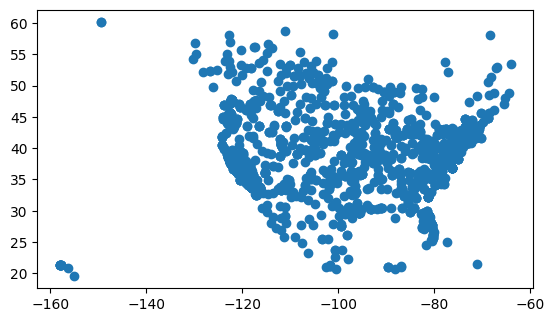

In [22]:
# View how geographically distributed they are (small number!)
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs="EPSG:4326"
)
gdf.plot()

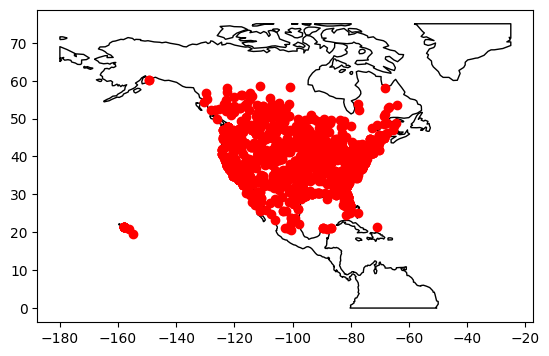

In [31]:
from geodatasets import get_path
import matplotlib.pyplot as plt
world = gpd.read_file(get_path("naturalearth.land"))

# We restrict to South America.
# ax = world.clip([-90, -55, -25, 15]).plot(color="white", edgecolor="black")

# Full world
ax = world.clip([-180, 0, -25, 75]).plot(color="white", edgecolor="black")
 # (xmin, ymin, xmax, ymax)

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red")
plt.show()

<Axes: >

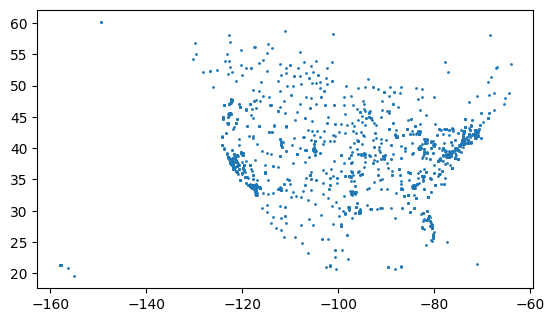

In [34]:
gdf.plot(markersize=1)

## Figure out how to restart from checkpoint logs

Basically need to figure out:

1. How to re-form batches by worker to skip all the tiles already checked
2. How to check that the last cell IDs we saw in the log belong to unique batches (no overlap)

In [36]:
# From logs, these are searchcell IDs
last_ids_scraped = [
    '5a8a4411-4a29-4122-91dd-45543ac3f467',
    '6e6f7f56-9c03-4db9-9c24-2b5fa79fb55a',
    '52674f0a-b24e-4223-abad-60ec6d741835',
    '4dfd3f13-15d9-483c-b95c-c13be2062fc9',
    'a9b40a51-7690-4647-a1c0-4b67fbf33373',
    'bdae829b-42d4-469a-acfe-6b41ec31956e',
    'ef4a47e0-0b2e-414f-8ef0-46af43e175e3'
]

tile_ids = bq.query_to_dataframe("SELECT id from evlens.plugshare.searchTiles")
tile_ids.head()

/Users/davemcrench/Projects/evlens/.venv/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,id
0,6394025e-d327-4cd7-bcd4-1f87f295ef09
1,4c2d3a79-bc76-4227-83d3-27cb250ec92a
2,c62e8526-7908-44c8-9030-334be92efeff
3,3d092ca5-eb1d-49dc-87eb-7a41a179f801
4,43598b85-ed78-42d7-868e-c12ffff7c887


In [37]:
last_ones = tile_ids[tile_ids['id'].isin(last_ids_scraped)]
last_ones

,id
11362,5a8a4411-4a29-4122-91dd-45543ac3f467
11365,bdae829b-42d4-469a-acfe-6b41ec31956e
270268,a9b40a51-7690-4647-a1c0-4b67fbf33373
529169,6e6f7f56-9c03-4db9-9c24-2b5fa79fb55a
529172,ef4a47e0-0b2e-414f-8ef0-46af43e175e3
1046974,4dfd3f13-15d9-483c-b95c-c13be2062fc9
1564731,52674f0a-b24e-4223-abad-60ec6d741835


In [38]:
# Where are these indices in the batches we pull together?
from evlens.concurrency import get_batches_by_worker

batches = get_batches_by_worker(tile_ids, 7)
batches

[                                          id
 0       6394025e-d327-4cd7-bcd4-1f87f295ef09
 1       4c2d3a79-bc76-4227-83d3-27cb250ec92a
 2       c62e8526-7908-44c8-9030-334be92efeff
 3       3d092ca5-eb1d-49dc-87eb-7a41a179f801
 4       43598b85-ed78-42d7-868e-c12ffff7c887
 ...                                      ...
 258898  a8a01a8c-6375-4335-8ffd-35d91cb0b7ea
 258899  a2b2600d-d4a6-4959-aa7a-d5f840943f63
 258900  776825fa-c9e9-400d-9630-d86f0d00ff33
 258901  62a9e288-08d0-4fed-86f6-69eca08f5bde
 258902  fb19aff2-8fcc-425d-8810-6823018de507
 
 [258903 rows x 1 columns],
                                           id
 258903  2dfa7705-1547-4e4c-8681-23574bbe48a8
 258904  f904b7d4-f61a-47e3-95b6-806f15f8f2b4
 258905  8bbc8b95-45e4-4785-ace6-995228f70503
 258906  ee41d839-4936-4a2a-ae4d-598cd4c374a3
 258907  aa2bc3e3-8390-4169-ba8f-b0e7d4e7b240
 ...                                      ...
 517801  05deef09-c2b6-4695-9e21-756a6ddedfba
 517802  9ced470c-8b8e-4fc4-b8df-5154257e0115
 517

In [55]:
# Add a column for batch_id to last_ones
last_ones['batch_id'] = np.nan

for idx, tile_id in last_ones.iterrows():
    for i, batch in enumerate(batches):
        if (batch['id'] == tile_id['id']).sum() > 0:
            last_ones.loc[idx, 'batch_id'] = i
         
last_ones['batch_id'] = last_ones['batch_id'].astype(int)

# Retain only the ones with the highest index
last_ones.sort_index(inplace=True)
last_ones.drop_duplicates(subset=['batch_id'], keep='last', inplace=True)
last_ones

/var/folders/98/fhwnl49n19l_xywxzghbm4jm0000gn/T/ipykernel_1405/2521151555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_ones['batch_id'] = np.nan
/var/folders/98/fhwnl49n19l_xywxzghbm4jm0000gn/T/ipykernel_1405/2521151555.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_ones['batch_id'] = last_ones['batch_id'].astype(int)
/var/folders/98/fhwnl49n19l_xywxzghbm4jm0000gn/T/ipykernel_1405/2521151555.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,id,batch_id
11365,bdae829b-42d4-469a-acfe-6b41ec31956e,0
270268,a9b40a51-7690-4647-a1c0-4b67fbf33373,1
529172,ef4a47e0-0b2e-414f-8ef0-46af43e175e3,2
1046974,4dfd3f13-15d9-483c-b95c-c13be2062fc9,4
1564731,52674f0a-b24e-4223-abad-60ec6d741835,6


In [58]:
num_workers = 7

missing_batches = []
for i in range(num_workers):
    if (last_ones.batch_id == i).sum() == 0:
        missing_batches.append(i)
        
if len(missing_batches) > 0:
    raise ValueError(f"Missing {len(missing_batches)} batches in the provided IDs, please go back further in the logs and find IDs for the following (zero-indexed) batches: {missing_batches}")

ValueError: Missing 2 batches in the provided IDs, please go back further in the logs and find IDs for the following (zero-indexed) batches: [3, 5]

In [94]:
# From logs, these are searchcell IDs
last_ids_scraped = [
    '3588c6fc-78b0-4f8c-95bc-7da86613a019',
    'b3c6acf2-e305-4042-96f1-4ec279169f8b',
    '1d914e10-2147-432c-86fe-4400f7a0b798',
    '3b34b50f-4c0d-424b-9a0a-63b23c5cf73e',
    '6212f1b0-4720-4966-8eb0-d0d1b65fea48',
    '52b4b028-b8a5-4eaf-834a-cd4d5df9f16e',
    '0b8a3cc1-bcb6-440a-8dbd-4b84d1d795d5',
]

n_jobs = 7
data = tile_ids
checkpoint_identifier = 'id'
checkpoint_values = last_ids_scraped

# Check if we can make new batches based off of checkpoint values
# Assume that checkpoint values are not needed themselves, but just the values in each batch AFTER checkpoint values
last_ones = data[data[checkpoint_identifier].isin(checkpoint_values)]
# Add a column for batch_id to last_ones
last_ones['batch_id'] = np.nan

for idx, checkpoint_id in last_ones.iterrows():
    for i, batch in enumerate(batches):
        if (batch['id'] == checkpoint_id['id']).sum() > 0:
            last_ones.loc[idx, 'batch_id'] = i
        
last_ones['batch_id'] = last_ones['batch_id'].astype(int)

# Retain only the ones with the highest index
last_ones.sort_index(inplace=True)
last_ones.drop_duplicates(subset=['batch_id'], keep='last', inplace=True)

missing_batches = []
for i in range(n_jobs):
    if (last_ones.batch_id == i).sum() == 0:
        missing_batches.append(i)
        
if len(missing_batches) > 0:
    raise ValueError(f"Missing {len(missing_batches)} batches in the provided IDs, please go back further in the logs and find IDs for the following (zero-indexed) batches: {missing_batches}")

/var/folders/98/fhwnl49n19l_xywxzghbm4jm0000gn/T/ipykernel_1405/800924795.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_ones['batch_id'] = np.nan
/var/folders/98/fhwnl49n19l_xywxzghbm4jm0000gn/T/ipykernel_1405/800924795.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_ones['batch_id'] = last_ones['batch_id'].astype(int)
/var/folders/98/fhwnl49n19l_xywxzghbm4jm0000gn/T/ipykernel_1405/800924795.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [97]:
last_ones#.reset_index()

,id,batch_id
21887,1d914e10-2147-432c-86fe-4400f7a0b798,0
280791,3588c6fc-78b0-4f8c-95bc-7da86613a019,1
539704,6212f1b0-4720-4966-8eb0-d0d1b65fea48,2
798595,3b34b50f-4c0d-424b-9a0a-63b23c5cf73e,3
1057508,0b8a3cc1-bcb6-440a-8dbd-4b84d1d795d5,4
1316308,52b4b028-b8a5-4eaf-834a-cd4d5df9f16e,5
1575209,b3c6acf2-e305-4042-96f1-4ec279169f8b,6


In [111]:
# Figure out how make new batches that start with these IDs (which is easier than ID + 1)
batch_id = 0

batches[0].loc[21886]

id    ac3f33e8-1d61-4408-90cf-c2472dd6d6c6
Name: 21886, dtype: object

In [118]:
starting_indices = last_ones.index.tolist()

new_batches = []
for idx, b in zip(starting_indices, batches):
    new_batches.append(b.loc[idx:])
    
new_batches

[                                          id
 21887   1d914e10-2147-432c-86fe-4400f7a0b798
 21888   6c2130a0-456f-4580-b7a4-e1d0790b919c
 21889   58a80d43-6803-4cba-b506-0d49021778b1
 21890   78584d7e-2012-45c9-b2ac-07df80056a4f
 21891   4f2f9fe3-a915-4818-9d9b-01b57f968127
 ...                                      ...
 258898  a8a01a8c-6375-4335-8ffd-35d91cb0b7ea
 258899  a2b2600d-d4a6-4959-aa7a-d5f840943f63
 258900  776825fa-c9e9-400d-9630-d86f0d00ff33
 258901  62a9e288-08d0-4fed-86f6-69eca08f5bde
 258902  fb19aff2-8fcc-425d-8810-6823018de507
 
 [237016 rows x 1 columns],
                                           id
 280791  3588c6fc-78b0-4f8c-95bc-7da86613a019
 280792  fc3e9867-39af-491e-8d8a-75b9a663f5e1
 280793  609ebb4a-f0b8-403e-a6d4-0f5afc5dc448
 280794  db021ab9-d974-492a-844b-43c705876a58
 280795  fd00c7c7-9f50-4782-af41-ee54a15e12f0
 ...                                      ...
 517801  05deef09-c2b6-4695-9e21-756a6ddedfba
 517802  9ced470c-8b8e-4fc4-b8df-5154257e0115
 517

In [120]:
[len(b) for b in batches]

[258903, 258903, 258902, 258902, 258902, 258902, 258902]

In [124]:
tile_ids

,id
0,6394025e-d327-4cd7-bcd4-1f87f295ef09
1,4c2d3a79-bc76-4227-83d3-27cb250ec92a
2,c62e8526-7908-44c8-9030-334be92efeff
3,3d092ca5-eb1d-49dc-87eb-7a41a179f801
4,43598b85-ed78-42d7-868e-c12ffff7c887
...,...
1812311,88fcea82-47c9-4eca-b0ab-4c3204eeaec3
1812312,9f271cec-9fb9-4e62-9b40-6ac94a668d85
1812313,f9dbd137-c53c-42f7-8766-ffd0e40c7317
1812314,3c878e43-543f-4412-a145-880b33b74c6e


In [126]:
from evlens.concurrency import get_batches_by_worker, get_batch_indices_from_identifiers

idxs = get_batch_indices_from_identifiers(tile_ids, checkpoint_values=last_ids_scraped, checkpoint_identifier='id')

new_batches = get_batches_by_worker(tile_ids, 7, idxs)
[len(b) for b in new_batches]

[237015, 237014, 237003, 237014, 237003, 237105, 237106]